# **Automatic Medical Report Generation**

**Import necessary library**

In [1]:
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
from transformers import GPT2TokenizerFast, GPT2LMHeadModel
import pandas as pd
from sklearn.model_selection import train_test_split
from PIL import Image
import torch.nn.functional as F
from tqdm import tqdm
import os

# Read and merge  csv files  
* Read the two given csv files and create a data frame by merging the two read files based on uid. 
* create an absolute path for the images[add a new image_path column]

In [2]:

# Paths to datasets
projections_path = "/kaggle/input/chest-xrays-indiana-university/indiana_projections.csv"
reports_path = "/kaggle/input/chest-xrays-indiana-university/indiana_reports.csv"
image_dir = "/kaggle/input/chest-xrays-indiana-university/images/images_normalized"

# Load datasets
projections = pd.read_csv(projections_path)
reports = pd.read_csv(reports_path)

# Validate presence of 'uid' column
if "uid" not in projections.columns or "uid" not in reports.columns:
    raise KeyError("Both CSV files must contain the 'uid' column.")

# Merge datasets on 'uid'
dataset = pd.merge(projections, reports, on="uid")

# Add full image paths
dataset["image_path"] = dataset["filename"].apply(lambda x: os.path.join(image_dir, x) if os.path.exists(os.path.join(image_dir, x)) else None)

# Drop rows without valid image paths
dataset = dataset.dropna(subset=["image_path"]).reset_index(drop=True)

print("Dataset Shape:", dataset.shape)
print(dataset.head())

Dataset Shape: (7466, 11)
   uid                filename projection  \
0    1  1_IM-0001-4001.dcm.png    Frontal   
1    1  1_IM-0001-3001.dcm.png    Lateral   
2    2  2_IM-0652-1001.dcm.png    Frontal   
3    2  2_IM-0652-2001.dcm.png    Lateral   
4    3  3_IM-1384-1001.dcm.png    Frontal   

                                                MeSH  \
0                                             normal   
1                                             normal   
2  Cardiomegaly/borderline;Pulmonary Artery/enlarged   
3  Cardiomegaly/borderline;Pulmonary Artery/enlarged   
4                                             normal   

                        Problems                                image  \
0                         normal            Xray Chest PA and Lateral   
1                         normal            Xray Chest PA and Lateral   
2  Cardiomegaly;Pulmonary Artery  Chest, 2 views, frontal and lateral   
3  Cardiomegaly;Pulmonary Artery  Chest, 2 views, frontal and lateral   
4

# Check if there is empty column
* check an empty column in file name findings, impression and drop out , 

In [3]:
#check number of missing values in each column
missing_count = dataset.isnull().sum()
print("\nMissing Counts:\n=\n",missing_count)
print("=" * 40)

# Drop rows with missing values in 'filename' or 'findings' or 'impression'
dataset = dataset.dropna(subset=["filename", "findings","impression"])
print("\n\nAfter Dropping Empty Columns:\n=\n")
#number of missing values after dropping empty row of filename,  findings and impression
missing_count_check = dataset.isnull().sum()
print(missing_count_check)
print("=" * 40)
#dataset shape
dataset.shape


Missing Counts:
=
 uid              0
filename         0
projection       0
MeSH             0
Problems         0
image            0
indication     159
comparison    2260
findings       997
impression      52
image_path       0
dtype: int64


After Dropping Empty Columns:
=

uid              0
filename         0
projection       0
MeSH             0
Problems         0
image            0
indication     103
comparison    1621
findings         0
impression       0
image_path       0
dtype: int64


(6457, 11)

# Checks if there are damaged images
* Check and count the number of healthy and damaged images.

In [4]:
import cv2
import pandas as pd


# Function to check if an image is valid
def is_image_valid(image_path):
    try:
        img = cv2.imread(image_path)
        if img is None:
            return False  # If OpenCV fails to read, it's invalid
        return True
    except Exception:
        return False

# Check the status of images in the 'image_path' column
def count_image_status_from_dataframe(frontal_lateral_df, column_name):
    valid_count = 0
    damaged_count = 0
    for image_path in frontal_lateral_df[column_name]:
        if is_image_valid(image_path):
            valid_count += 1
        else:
            damaged_count += 1
    return valid_count, damaged_count

# Run the count based on the DataFrame
valid_images, damaged_images = count_image_status_from_dataframe(dataset, 'image_path')

# Print the summary
print("\n=\n")
print(f"Total images: {valid_images + damaged_images}")
print(f"Valid images: {valid_images}")
print(f"Damaged images: {damaged_images}")
print("=" * 40)


=

Total images: 6457
Valid images: 6457
Damaged images: 0


# Distribution of uid occurrence
count and displays the occurance of uid in the dataset in bar.
This is very important to know how many images a unique user[uid] has in the dataset and to prepare the final dataset based on the characteristics of the original dataset.

Purpose of this visualization:
*   This helps in understanding the distribution of images per UID in the dataset.
*   You can see if the dataset is balanced (i.e., most UIDs have similar image counts) or imbalanced (some UIDs have many images, and others have few).

Occurrence Distribution:

Occurrence 	 Number of uids
 1 		 382
 2 		 2786
 3 		 150
 4 		 12
 5 		 1


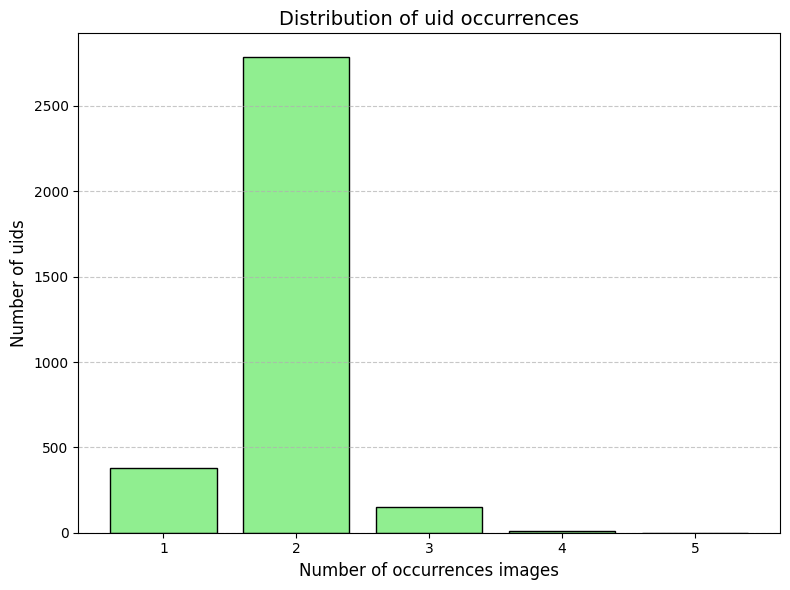

In [5]:
#bar plot for the uid occurance
import matplotlib.pyplot as plt

# Group by uid and count occurrences
uid_counts = dataset['uid'].value_counts()

# Count the number of UIDs with specific occurrences
occurrence_counts = uid_counts.value_counts().sort_index()

# print("Index: ", occurrence_counts.index, " \n  Num: ",  occurrence_counts.values)
print("Occurrence Distribution:\n")
print("=" * 40)
print("Occurrence \t Number of uids")
print("=" * 40)
for count, num_uids in zip(occurrence_counts.index, occurrence_counts.values):
    print(f" {count} \t\t {num_uids}")
# Plot the distribution
plt.figure(figsize=(8, 6))
plt.bar(occurrence_counts.index, occurrence_counts.values, color='lightgreen', edgecolor='black')

# Add labels and title
plt.xlabel('Number of occurrences images', fontsize=12)
plt.ylabel('Number of uids', fontsize=12)
plt.title('Distribution of uid occurrences', fontsize=14)
plt.xticks(occurrence_counts.index)  # Ensure x-axis ticks match occurrence counts
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.tight_layout()
plt.show()

# Constructing Data Frame 
From the above uid distribution, all users(uids) have no equal number of chest x-ray image, so the following action are taken.

* for having consistent and balanced dataset, uids that contains only Frontal or Lateral images are dropped,
* only one Frontal or Lateral image is taken , for uids that have more than one Frontal or Lateral images, 
* a new dataframe called frontal_lateral_df , that contains columns , uid, frontal_image, lateral_image, impressions, and findings is created.





In [6]:
# Step 1: Group by uid and filter users with both Frontal and Lateral projections

filtered_uids = dataset.groupby('uid')['projection'].apply(lambda x: {'Frontal', 'Lateral'}.issubset(set(x)))
valid_uids = filtered_uids[filtered_uids].index

# Step 2: Filter dataset to keep only valid users
filtered_dataset = dataset[dataset['uid'].isin(valid_uids)]

# Step 3: Get one Frontal and one Lateral image per uid
def select_one_image(frontal_lateral_df, projection_type):
    selected = frontal_lateral_df[frontal_lateral_df['projection'] == projection_type]
    return selected.head(1)  # Take the first occurrence

# Create a new DataFrame
result = []
for uid, group in filtered_dataset.groupby('uid'):
    frontal_image = select_one_image(group, 'Frontal')
    lateral_image = select_one_image(group, 'Lateral')

    # Combine the selected Frontal and Lateral along with findings and impression
    if not frontal_image.empty and not lateral_image.empty:
        result.append({
            'uid': uid,
            'frontal_image': frontal_image.iloc[0]['image_path'],
            'lateral_image': lateral_image.iloc[0]['image_path'],
            'findings': frontal_image.iloc[0]['findings'],  # Assuming findings are the same for all images of the same uid
            'impressions': frontal_image.iloc[0]['impression'], 
        })

# Step 4: Create the final DataFrame
frontal_lateral_df = pd.DataFrame(result)

print(frontal_lateral_df.head())  # Display the first few rows


   uid                                      frontal_image  \
0    1  /kaggle/input/chest-xrays-indiana-university/i...   
1    2  /kaggle/input/chest-xrays-indiana-university/i...   
2    4  /kaggle/input/chest-xrays-indiana-university/i...   
3    5  /kaggle/input/chest-xrays-indiana-university/i...   
4    6  /kaggle/input/chest-xrays-indiana-university/i...   

                                       lateral_image  \
0  /kaggle/input/chest-xrays-indiana-university/i...   
1  /kaggle/input/chest-xrays-indiana-university/i...   
2  /kaggle/input/chest-xrays-indiana-university/i...   
3  /kaggle/input/chest-xrays-indiana-university/i...   
4  /kaggle/input/chest-xrays-indiana-university/i...   

                                            findings  \
0  The cardiac silhouette and mediastinum size ar...   
1  Borderline cardiomegaly. Midline sternotomy XX...   
2  There are diffuse bilateral interstitial and a...   
3  The cardiomediastinal silhouette and pulmonary...   
4  Heart size an

In [7]:
# Count the number of valid uids
num_valid_uids = len(valid_uids)

# Get the set of all uids in the original dataset
all_uids = set(dataset['uid'])

# Calculate invalid uids by subtracting the valid ones from all uids
invalid_uids = all_uids - set(valid_uids)
num_invalid_uids = len(invalid_uids)
print("=" * 40)
print(f"Number of valid uids: {num_valid_uids}")
print(f"Number of invalid uids (dropped): {num_invalid_uids}")
print("=" * 40)

Number of valid uids: 2937
Number of invalid uids (dropped): 394


# Display sample frontal, lateral images,findings, and impression of a random uid

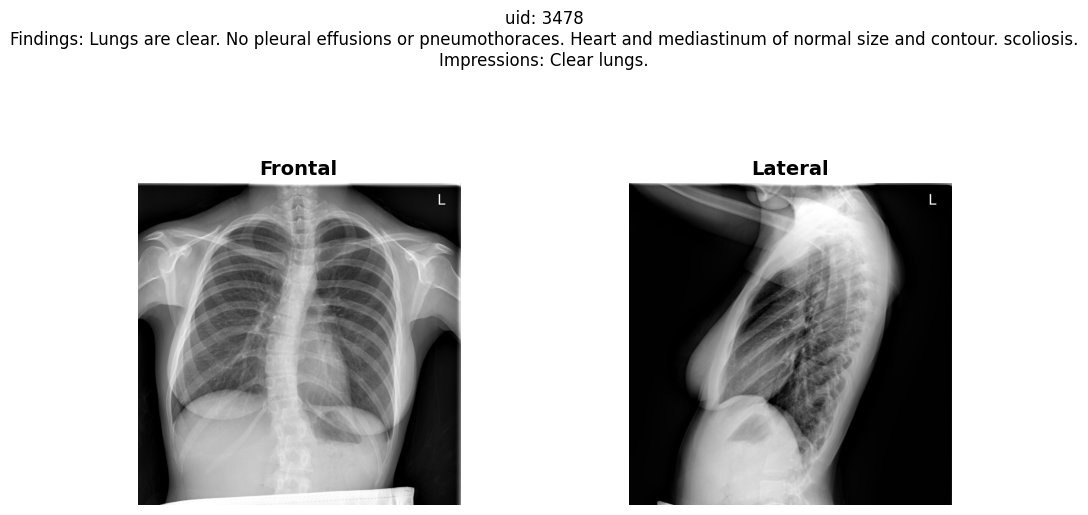

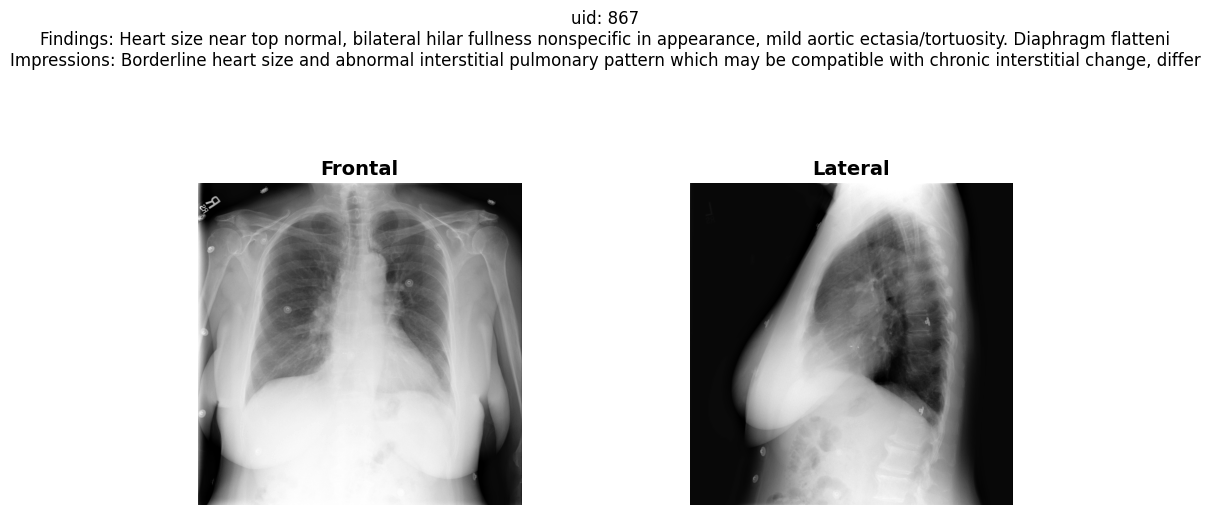

In [8]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

# Select 2 random uids
sample_data = frontal_lateral_df.sample(2, random_state=42)

for idx, row in sample_data.iterrows():
    fig_row, ax_images = plt.subplots(1, 2, figsize=(10, 5))  # 1 row, 2 columns

    # Load images
    frontal_image = mpimg.imread(row['frontal_image'])
    lateral_image = mpimg.imread(row['lateral_image'])

    # Display Frontal Image
    ax_images[0].imshow(frontal_image, cmap='gray')
    ax_images[0].set_title("Frontal", fontsize=14, fontweight='bold')
    ax_images[0].axis('off')

    # Display Lateral Image
    ax_images[1].imshow(lateral_image, cmap='gray')
    ax_images[1].set_title("Lateral", fontsize=14, fontweight='bold')
    ax_images[1].axis('off')

    # Set distance between images to zero
    plt.subplots_adjust(wspace=0, hspace=0)  # No spacing between images

    # Add findings and impressions as a common title
   # Combine findings and impressions into a single title
    title = (
        f"uid: {row['uid']}\n"
        f"Findings: {row['findings'][:130]}\n"
        f"Impressions: {row['impressions'][:130]}"
    )
    
    # Add the combined title to the plot
    plt.suptitle(title, fontsize=12, y=1.02)  # y=1.02 adjusts the title position slightly above the plot
    
    plt.tight_layout(rect=[0, 0, 1, 0.9])

plt.show()


# Reduce Dataset size to avoid memory limits in kaggle or colab notebook training
* a fraction of the created dataframe is randomly droped


==
Shape of the Dataset Before Reducing: (2937, 5)
Shape of the Dataset After Reducing: (2056, 5)
	Minimum length	Maximum length
Findings    	8	149
Impressions   	1	119


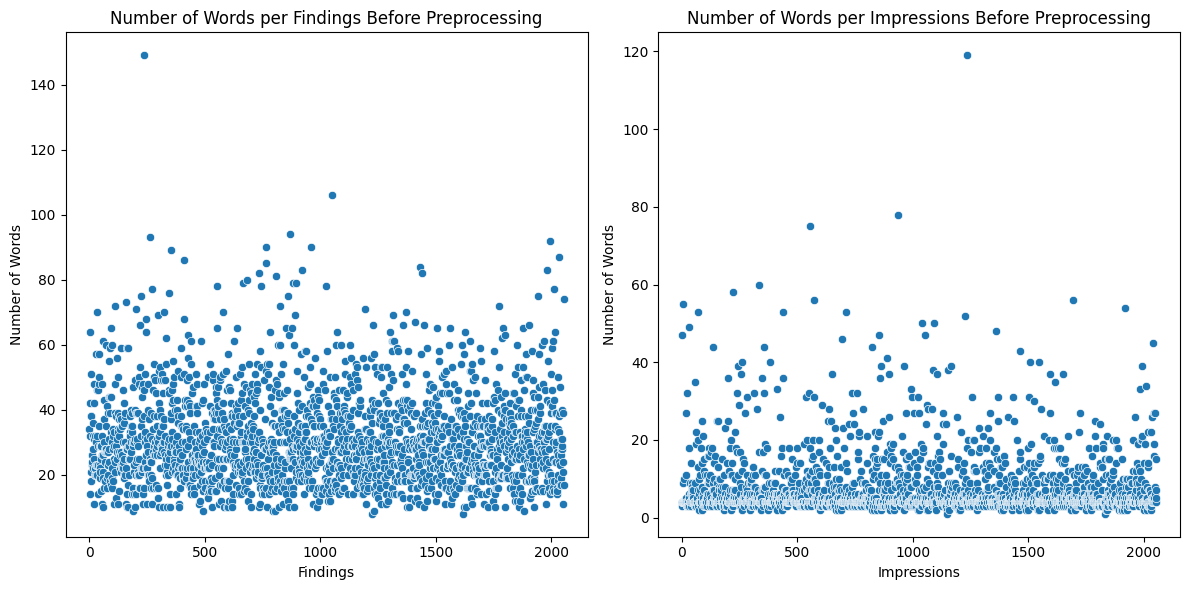

In [9]:
print("\n==")
print(f"Shape of the Dataset Before Reducing: {frontal_lateral_df.shape}")

frontal_lateral_df = frontal_lateral_df.drop(frontal_lateral_df.sample(frac=0.3, random_state=42).index)
print(f"Shape of the Dataset After Reducing: {frontal_lateral_df.shape}")
print("=" * 40)

# Minimum and Maximum word length in Findings and Impressions
count_words_finding = [len(e.split()) for e in frontal_lateral_df['findings'].values]
count_words_impression = [len(e.split()) for e in frontal_lateral_df['impressions'].values]

print(f"\tMinimum length\tMaximum length")
print(f"Findings    \t{min(count_words_finding)}\t{max(count_words_finding)}")
print(f"Impressions   \t{min(count_words_impression)}\t{max(count_words_impression)}")

print("=" * 40)


"Visualize word length"
import matplotlib.pyplot as plt
import seaborn as sns

# Create a 1-row, 2-column figure
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# First subplot: Findings word count
axes[0].set_title('Number of Words per Findings Before Preprocessing')
sns.scatterplot(x=range(frontal_lateral_df.shape[0]), y=count_words_finding, ax=axes[0])
axes[0].set_ylabel('Number of Words')
axes[0].set_xlabel('Findings')

# Second subplot: Impressions word count
axes[1].set_title('Number of Words per Impressions Before Preprocessing')
sns.scatterplot(x=range(frontal_lateral_df.shape[0]), y=count_words_impression, ax=axes[1])
axes[1].set_ylabel('Number of Words')
axes[1].set_xlabel('Impressions')

# Show the plot
plt.tight_layout()
plt.show()


# Preprocessing text data
For findings and impression columns the following text preprocessing are done.
* all texts are changed to lower case
* decontractions of words ex. won't to will not
* punctuations  are removed(full stop is not removed)
* Irrelevant texts are removed ex. XXXX
* multiple fullstops
* multiple spaces are removed
  

In [10]:
pip install contractions

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.7/110.7 kB 7.2 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [11]:
import contractions
import re


def lowercase(text):
    '''Converts to lowercase'''
    new_text = []
    for line in text:
        new_text.append(line.lower())
    return new_text 


def decontractions(text):
    '''Performs decontractions in the doc using the contractions library'''
    new_text = []
    for phrase in text:
        expanded_phrase = contractions.fix(phrase)
        new_text.append(expanded_phrase)
    return new_text


def rem_punctuations(text):
    '''Removes punctuations'''
    punctuations = '''!()-[]{};:'"\,<>/?@#$%^&*~''' # full stop is not removed
    new_text = []
    for line in text:
        for char in line:
            if char in punctuations:
                line = line.replace(char, "")
        new_text.append(' '.join(e for e in line.split()))
    return new_text

def rem_irrelevant_text(text):
    '''Removes irrelevant text like xx*'''
    new_text = []
    for line in text:
        temp = re.sub(r'\bxx*\b','',line)
        new_text.append(temp)
    return new_text

def multiple_fullstops(text):
    ''' Removes multiple full stops from the text'''
    new_text = []
    for line in text:
        new_text.append(re.sub(r'\.\.+', '.', line))
    return new_text

def multiple_spaces(text):
    new_text = []
    for line in text:
        new_text.append(' '.join(e for e in line.split()))
    return new_text

def separting_startg_words(text):
    ''' The function handles words starting with a period (.),
    adding a space after the period in cases where the word starts with a period.'''
    new_text = []
    for line in text:
        temp = []
        words = line.split()
        for i in words:
            if i.startswith('.') == False:
                temp.append(i)
            else:
                w = i.replace('.','. ')
                temp.append(w)
        new_text.append(' '.join(e for e in temp))
    return new_text

def rem_apostrophes(text):
    new_text = []
    for line in text:
        new_text.append(re.sub("'",'',line))
    return new_text

	Minimum length	Maximum length
Findings    	8	147
Impressions   	1	114


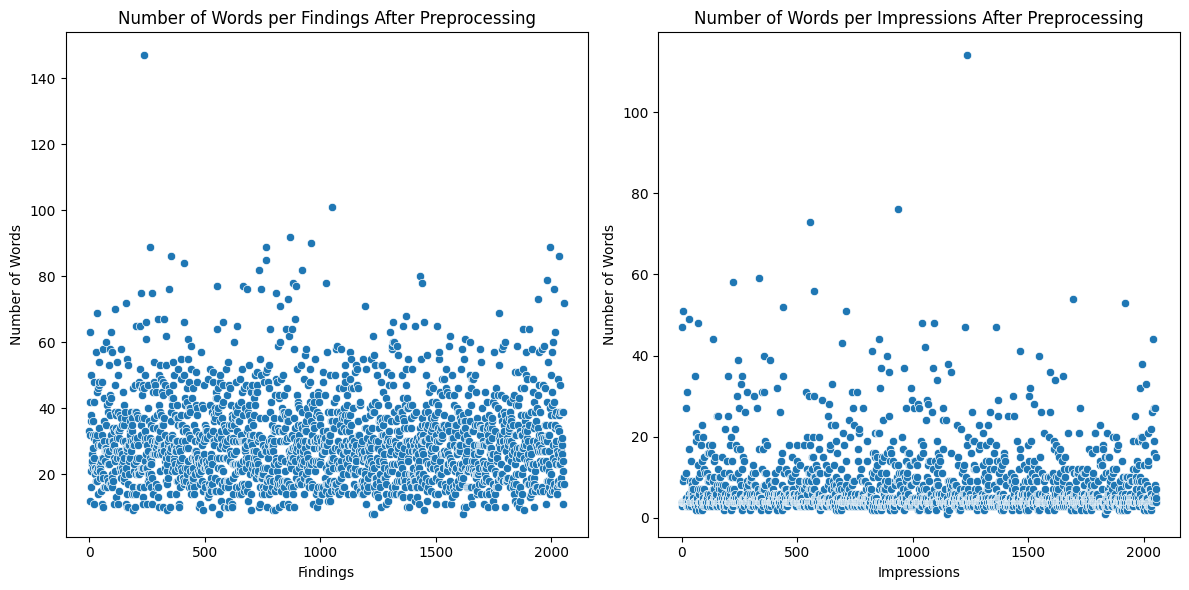

In [12]:
def text_preprocessing(text):
    '''Cascade all the preprocess functions'''
    new_text = lowercase(text)
    new_text = decontractions(new_text)
    new_text = rem_punctuations(new_text)
    new_text = rem_irrelevant_text(new_text)
    new_text = multiple_fullstops(new_text)
    new_text = multiple_spaces(new_text)
    new_text = separting_startg_words(new_text)
    new_text = rem_apostrophes(new_text)
    return new_text


# invoke text_preprocessing for findings, and impressions
frontal_lateral_df['findings'] = text_preprocessing(frontal_lateral_df['findings'])
frontal_lateral_df['impressions'] = text_preprocessing(frontal_lateral_df['impressions'])

# Minimum and Maximum word length in Findings and Impressions
count_words_finding = [len(e.split()) for e in frontal_lateral_df['findings'].values]
count_words_impression = [len(e.split()) for e in frontal_lateral_df['impressions'].values]

print("=" * 40)
print(f"\tMinimum length\tMaximum length")
print(f"Findings    \t{min(count_words_finding)}\t{max(count_words_finding)}")
print(f"Impressions   \t{min(count_words_impression)}\t{max(count_words_impression)}")

print("=" * 40)


"Visualize word length"
import matplotlib.pyplot as plt
import seaborn as sns

# Create a 1-row, 2-column figure
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# First subplot: Findings word count
axes[0].set_title('Number of Words per Findings After Preprocessing')
sns.scatterplot(x=range(frontal_lateral_df.shape[0]), y=count_words_finding, ax=axes[0])
axes[0].set_ylabel('Number of Words')
axes[0].set_xlabel('Findings')

# Second subplot: Impressions word count
axes[1].set_title('Number of Words per Impressions After Preprocessing')
sns.scatterplot(x=range(frontal_lateral_df.shape[0]), y=count_words_impression, ax=axes[1])
axes[1].set_ylabel('Number of Words')
axes[1].set_xlabel('Impressions')

# Show the plot
plt.tight_layout()
plt.show()


# Load Tokenizer
* GPT2 tokenizer which is  tokenizer for the GPT-2 model is loaded using the from_pretrained() method.
* padding token (pad_token) is set for the tokenizer.

In [13]:
from transformers import AutoTokenizer, GPT2TokenizerFast

# The tokenizer is used to transform text into sequences of tokens (minimal units of meaning for the model) and vice versa.

tokenizer = GPT2TokenizerFast.from_pretrained('gpt2')

# The padding token (pad_token) is set for the tokenizer. 
tokenizer.pad_token = tokenizer.eos_token



tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

# Image preprocessing
* Images are preprocessed  and made ready for extraction using ResNet50, a pretrained CNN model
* Images are transformed to the same size , and normilized and some data augmentation practice is made on the images. 

In [14]:
from torchvision import transforms

transform = transforms.Compose([
    transforms.Resize((384, 384)), # Resize the images to the standard format
    transforms.RandomHorizontalFlip(p=0.3),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),  # Transform the image into a PyTorch tensor. This operation normalizes the pixel values
])

# Tokenize findings and impression 


In [15]:
from torch.utils.data import Dataset
from PIL import Image

class DatasetLoader(Dataset):
    def __init__(self, frontal_lateral_df):
        self.frontal_images = frontal_lateral_df['frontal_image'].values  # Column of frontal images
        self.lateral_images = frontal_lateral_df['lateral_image'].values  # Column of lateral images
        self.findings = frontal_lateral_df['findings'].values  # Column of findings
        self.impressions = frontal_lateral_df['impressions'].values  # Column of impressions
        
        
    # The __getitem__ method retrieves the frontal and lateral images and the corresponding finding
    def __getitem__(self, idx):
        # Load the frontal and lateral images
        frontal_image_path = str(self.frontal_images[idx])
        lateral_image_path = str(self.lateral_images[idx])
        
        # Open the images and convert them to RGB
        frontal_image = Image.open(frontal_image_path).convert("RGB")
        lateral_image = Image.open(lateral_image_path).convert("RGB")
        
        # Apply transformations to the images (to be defined)
        frontal_image = transform(frontal_image)
        lateral_image = transform(lateral_image)

          # Add prompts to findings and impressions
        finding =  " Findings: " +str(self.findings[idx])
        impression = "Impressions: " + str(self.impressions[idx])

      
    
        # Encode the finding using the tokenizer
        encoded_finding = tokenizer(
            finding,
            max_length=80,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )
      
        encoded_impression = tokenizer(
            impression,
            max_length=40,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )
 
              
        # Return the images and the encoded finding and encoded impression
        return {
            'front_pixel_values': frontal_image,  # Frontal image
            'lateral_pixel_values': lateral_image,  # Lateral image
            'input_ids_finding': encoded_finding['input_ids'].squeeze(0),  # Input IDs of the finding
            'attention_mask_finding': encoded_finding['attention_mask'].squeeze(0),  # Attention Mask for the finding
            'input_ids_impression': encoded_impression['input_ids'].squeeze(0),  # Input IDs of the finding
            'attention_mask_impression': encoded_impression['attention_mask'].squeeze(0),  # Attention Mask for the finding
           
        }

    def __len__(self):  # Method that returns the length of the dataset
        return len(self.frontal_images)

# Data splitting
* Training: 76.5%
* Validation: 13.5%
* Test: 10% 

In [16]:
from sklearn.model_selection import train_test_split

# Split the DataFrame into train, test, and validation sets
train_frontal_lateral_df, test_frontal_lateral_df = train_test_split(frontal_lateral_df, test_size=0.1, shuffle=True, random_state=42)
train_frontal_lateral_df, valid_frontal_lateral_df = train_test_split(train_frontal_lateral_df, test_size=0.15, shuffle=True, random_state=42)

# Create custom datasets for train, test, and validation
train_ds = DatasetLoader(train_frontal_lateral_df)
test_ds = DatasetLoader(test_frontal_lateral_df)
valid_ds = DatasetLoader(valid_frontal_lateral_df)

# Print the shape of each dataset
print("=" * 80)
print(f"Training dataset size: {len(train_ds)} samples")
print(f"Testing dataset size: {len(test_ds)} samples")
print(f"Validation dataset size: {len(valid_ds)} samples\n")


# Print only one tokenized data and its attention mask for finding and impression
sample_idx = 0  # Change this index to print a different sample
sample = train_ds[sample_idx]

print("=" * 80)
print(f"Sample Tokenized finding:\n {sample['input_ids_finding']}\n")
print(f"Sample attention mask finding:\n {sample['attention_mask_finding']}\n")
print("=" * 80)
print(f"Sample Tokenized impression:\n {sample['input_ids_impression']}\n")
print(f"Sample attention mask impression:\n {sample['attention_mask_impression']}\n")
print("=" * 80)

Training dataset size: 1572 samples
Testing dataset size: 206 samples
Validation dataset size: 278 samples

Sample Tokenized finding:
 tensor([ 9938,   654,    25, 25419,   876,  2458,   286,   262, 41899,   330,
          291, 19656,    13,  2612,  2546,  3487,    13, 21726,   389,  1598,
           13,   645, 29631,   849,   273,   897,   393,  3339,  1523,   914,
         4241,    13,  1877, 12317, 15343,    13, 50256, 50256, 50256, 50256,
        50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
        50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
        50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
        50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256])

Sample attention mask finding:
 tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

# Define the Pretrained ResNet50 CNN model
* A pretrained CNN model, ResNet50 is used for extraction of features of images.
* The classification head of the ResNet50 model is removed, (as we are using the the model for feature extraction)

In [17]:
import torch
import torch.nn as nn
from torchvision import models

class ResNetEncoder(nn.Module):
    def __init__(self, trainable_layers=6):
        super(ResNetEncoder, self).__init__()
        self.model = models.resnet50(pretrained=True)
        # Remove the classification head
        self.model.fc = nn.Identity()
        
        # Freeze all layers
        for param in self.model.parameters():
            param.requires_grad = False
        
        # Unfreeze the last `trainable_layers` layers
        self._unfreeze_last_layers(trainable_layers)

    def _unfreeze_last_layers(self, trainable_layers):
        # Get the layers in order (children) and unfreeze the last n
        children = list(self.model.children())  
        for layer in children[-trainable_layers:]:
            for param in layer.parameters():
                param.requires_grad = True

    def forward(self, x):
        # Return the feature vector (dim=2048)
        return self.model(x)  # shape [B, 2048]

# Define the Multimodal model
* The model combines image feature extraction using ResNet encoders with a text generation component based on GPT-2. The generated report is divided into two sections: Findings and Impressions.
* **ResNet Encoders**: Two ResNet-based encoders (encoder_front and encoder_lateral) are used to extract features from frontal and lateral medical images, respectively. These encoders are partially trainable (only the last 4 layers are trainable).
* **GPT-2 Decoder**: A GPT-2 model (GPT2LMHeadModel) is used as the decoder for **text generation**. It is configured with cross-attention to incorporate image features into the text generation process.
* **Report generation**: The generate_reports method generates medical reports from the input images.

In [18]:
from transformers import GPT2Config, GPT2LMHeadModel

class MedicalReportModel(nn.Module):
    def __init__(self,tokenizer, dropout_rate=0.4):
        super(MedicalReportModel, self).__init__()
         # Store the tokenizer
        self.tokenizer = tokenizer
        # ResNet encoders
        self.encoder_front = ResNetEncoder(trainable_layers=4)
        self.encoder_lateral = ResNetEncoder(trainable_layers=4)

        # GPT-2 Decoder Configuration with Regularization
        config = GPT2Config.from_pretrained('gpt2')
        config.add_cross_attention = True
        
        # Increase dropout rates in the decoder
        config.resid_pdrop = dropout_rate  # Dropout for residual layers
        config.attn_pdrop = dropout_rate   # Dropout for attention layers
        config.embd_pdrop = dropout_rate   # Dropout for embeddings
        
        self.decoder = GPT2LMHeadModel.from_pretrained('gpt2', config=config)

        # Freeze first layer and embeddings
        for name, param in self.decoder.named_parameters():
            if "wte" in name or "h.0" in name:
                param.requires_grad = False

        # Feature projection with dropout
        self.feature_projection = nn.Linear(2048 * 2, self.decoder.config.hidden_size)
        self.projection_layer_norm = nn.LayerNorm(self.decoder.config.hidden_size)
        self.dropout = nn.Dropout(dropout_rate)  # Dropout after projection

    def forward(self, frontal_image, lateral_image, input_ids_finding, attention_mask_finding, input_ids_impression, attention_mask_impression):
        # Extract image features
        frontal_image_features = self.encoder_front(frontal_image)
        lateral_image_features = self.encoder_lateral(lateral_image)
        
        # Concatenate and project features
        combined_features = torch.cat((frontal_image_features, lateral_image_features), dim=-1)
        projected_features = self.feature_projection(combined_features)
        projected_features = self.projection_layer_norm(projected_features)
        projected_features = self.dropout(projected_features)  # Apply dropout
        
        # Expand features for decoder input
        seq_length_findings = input_ids_finding.shape[1]
        projected_features_findings = projected_features.unsqueeze(1).expand(-1, seq_length_findings, -1).contiguous()

        seq_length_impressions = input_ids_impression.shape[1]
        projected_features_impressions = projected_features.unsqueeze(1).expand(-1, seq_length_impressions, -1).contiguous()
        
        # Decode findings and impressions
        finding_outputs = self.decoder(
            input_ids=input_ids_finding,
            attention_mask=attention_mask_finding,
            labels=input_ids_finding,
            encoder_hidden_states=projected_features_findings,
            output_hidden_states=True
        )

        impression_outputs = self.decoder(
            input_ids=input_ids_impression,
            attention_mask=attention_mask_impression,
            labels=input_ids_impression,
            encoder_hidden_states=projected_features_impressions,
            output_hidden_states=True
        )
        
        return {
            'finding_outputs': finding_outputs,
            'impression_outputs': impression_outputs,
        }
   
    def generate_reports(self, frontal_image, lateral_image, max_length=60, device=None):
        # Combine the latent space
        frontal_image_features = self.encoder_front(frontal_image)
        lateral_image_features = self.encoder_lateral(lateral_image)
        combined_features = torch.cat((frontal_image_features, lateral_image_features), dim=-1)
        projected_features = self.feature_projection(combined_features)
        projected_features = self.projection_layer_norm(projected_features)
        projected_features = self.dropout(projected_features)  # Apply dropout
        projected_features = projected_features.unsqueeze(1)  # Shape: [B, 1, hidden_size]
    
        batch_size = frontal_image.size(0)
    
        # Generate Findings section
        findings_prompt = "Findings:"
        findings_start = self.decoder.transformer.wte(
                            torch.tensor([self.decoder.config.bos_token_id]).to(device)
                        ).unsqueeze(0).expand(batch_size, -1, -1)  # Shape: [B, 1, hidden_size]

        
        findings_start = findings_start + self.decoder.transformer.wte(
                                torch.tensor([self.tokenizer.encode(findings_prompt)[0]]).to(device)
                            ).unsqueeze(0).expand(batch_size, -1, -1)  # Add prompt embeddings

        
        findings_attention_mask = torch.ones(batch_size, 1).to(device)
    
        findings_ids= self.decoder.generate(
            input_ids=None,  # No input IDs, using embeddings directly
            inputs_embeds=findings_start,
            attention_mask=findings_attention_mask,
            encoder_hidden_states=projected_features.contiguous(),
            max_length=max_length,
            pad_token_id=self.tokenizer.eos_token_id,
            do_sample=True
        )
    
        # Generate Impressions section
        impressions_prompt = "Impressions:"
        
        impressions_start = self.decoder.transformer.wte(
            torch.tensor([self.decoder.config.bos_token_id]).to(device)
        ).unsqueeze(0).expand(batch_size, -1, -1)  # Shape: [B, 1, hidden_size]
       
        impressions_start = impressions_start + self.decoder.transformer.wte(
                                torch.tensor([self.tokenizer.encode(impressions_prompt)[0]]).to(device)
                            ).unsqueeze(0).expand(batch_size, -1, -1)  # Add prompt embeddings
    
        
        impressions_attention_mask = torch.ones(batch_size, 1).to(device)
    
        impression_ids = self.decoder.generate(
            input_ids=None,  # No input IDs, using embeddings directly
            inputs_embeds=impressions_start,
            attention_mask=impressions_attention_mask,
            encoder_hidden_states=projected_features.contiguous(),
            max_length=max_length,
            pad_token_id=self.tokenizer.eos_token_id,
            do_sample=True
        )
     
        return findings_ids, impression_ids
        # return {
        #     'findings': generated_findings,
        #     'impressions': generated_impressions
        # }

In [19]:
import torch

# If the model exists and is on the GPU, free it
if 'model' in globals() and model is not None:
    del model  # delete the reference to the previous model
    torch.cuda.empty_cache()  # clear the unused GPU memory
    
model = MedicalReportModel(tokenizer=tokenizer) # create an instance of the above model containing resnet+ decoder gpt2
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model.to(device)  # OPTIMIZATION: If the GPU is available, the model will be transferred to the GPU to take advantage 
# of parallel computing power, significantly improving performance.

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 213MB/s]


model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

Some weights of GPT2LMHeadModel were not initialized from the model checkpoint at gpt2 and are newly initialized: ['h.0.crossattention.c_attn.bias', 'h.0.crossattention.c_attn.weight', 'h.0.crossattention.c_proj.bias', 'h.0.crossattention.c_proj.weight', 'h.0.crossattention.q_attn.bias', 'h.0.crossattention.q_attn.weight', 'h.0.ln_cross_attn.bias', 'h.0.ln_cross_attn.weight', 'h.1.crossattention.c_attn.bias', 'h.1.crossattention.c_attn.weight', 'h.1.crossattention.c_proj.bias', 'h.1.crossattention.c_proj.weight', 'h.1.crossattention.q_attn.bias', 'h.1.crossattention.q_attn.weight', 'h.1.ln_cross_attn.bias', 'h.1.ln_cross_attn.weight', 'h.10.crossattention.c_attn.bias', 'h.10.crossattention.c_attn.weight', 'h.10.crossattention.c_proj.bias', 'h.10.crossattention.c_proj.weight', 'h.10.crossattention.q_attn.bias', 'h.10.crossattention.q_attn.weight', 'h.10.ln_cross_attn.bias', 'h.10.ln_cross_attn.weight', 'h.11.crossattention.c_attn.bias', 'h.11.crossattention.c_attn.weight', 'h.11.crossat

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

MedicalReportModel(
  (encoder_front): ResNetEncoder(
    (model): ResNet(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          

# Print model parametres

In [20]:
# Function to count parameters
def count_parameters(model):
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    frozen_params = total_params - trainable_params
    return total_params, trainable_params, frozen_params

# Print the parameter count
total_params, trainable_params, frozen_params = count_parameters(model)
print(f"Total number of parameters: {total_params}")
print(f"Trainable parameters: {trainable_params}")
print(f"Frozen parameters: {frozen_params}")

count_parameters(model)

Total number of parameters: 202970752
Trainable parameters: 152031744
Frozen parameters: 50939008


(202970752, 152031744, 50939008)

# Prepare data based on batch size and shuffle for train

In [21]:
class CustomDataLoader:
    def __init__(self, dataloader, shuffle=False, limit_batches=None): # func is a function used to preprocess and move the tensor to GPU
        self.dataloader = dataloader
        self.shuffle = shuffle
        self.address = []
        self.limit_batches = limit_batches
        self.dataset = dataloader.dataset  # Add this line
        batches = iter(self.dataloader)
        
        # Load only the first 'limit_batches' batches if specified
        for i, b in enumerate(batches):
            if self.limit_batches and i >= self.limit_batches:
                break
            self.address.append(b)
            print(f"{i + 1}/{len(batches)} ----- {int(((i+1)/len(batches)) * 100)}% batches loaded", end="\r")
        # print()
        print(f"\nLoaded {len(self.address)} batches.")

    def __len__(self):
        return len(self.dataloader)

    def __iter__(self):
        if self.shuffle:
            random.shuffle(self.address)
            return iter(self.address)
        return iter(self.address)

# The batch_preprocessor function is used to prepare the data for batch processing. It transforms dict objects 
# (containing images, attention masks, input IDs, risk categories, etc.) into tensors and moves them to the GPU if available.
# It uses torch.stack to create a batch of tensors for each of the keys in the batch. The resulting tensors are transferred 
# to the GPU or CPU based on the availability of the GPU.
def batch_preprocessor(batch):
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
    
    front_pixel_values = torch.stack([item['front_pixel_values'] for item in batch]).to(device)
    lateral_pixel_values = torch.stack([item['lateral_pixel_values'] for item in batch]).to(device)
    input_ids_finding = torch.stack([item['input_ids_finding'] for item in batch]).to(device)
    attention_mask_finding = torch.stack([item['attention_mask_finding'] for item in batch]).to(device)
    input_ids_impression = torch.stack([item['input_ids_impression'] for item in batch]).to(device)
    attention_mask_impression = torch.stack([item['attention_mask_impression'] for item in batch]).to(device)
   
    return {
        'front_pixel_values': front_pixel_values,
        'lateral_pixel_values': lateral_pixel_values,
        'input_ids_finding': input_ids_finding,
        'attention_mask_finding': attention_mask_finding,
        'input_ids_impression': input_ids_impression,
        'attention_mask_impression': attention_mask_impression,
            }
    
# Set up data loaders
print("\nLoad Train Dataset")
print("=" * 40)
train_loader = DataLoader(train_ds, batch_size=8, shuffle=True, collate_fn=batch_preprocessor)
train_loader = CustomDataLoader(train_loader)



print("\n\nLoad Validation Dataset")
print("=" * 40)
val_loader = DataLoader(valid_ds, batch_size=8, shuffle=False, collate_fn=batch_preprocessor)
val_loader = CustomDataLoader(val_loader)


Load Train Dataset
197/197 ----- 100% batches loaded
Loaded 197 batches.


Load Validation Dataset
35/35 ----- 100% batches loaded
Loaded 35 batches.


# Calculate Finding Loss
* This code defines a custom loss function, MedicalFindingLoss, specifically designed for training models that generate medical findings from X-ray images or other medical data. The loss function emphasizes the accurate prediction of critical medical terms and anatomical locations by applying higher weights to these terms during training. This ensures that the model prioritizes clinically relevant information in the generated findings

In [22]:
class MedicalFindingLoss(torch.nn.Module):
    """
    This custom loss function is specifically designed for the medical findinging task, 
    where the focus is on accurately describing medical findings in X-ray images. 
    It incorporates weighting to emphasize critical medical terms and anatomical locations in the generated findings.
    """
    
    def __init__(self, tokenizer, penality_terms_weight=2.0):
        super().__init__()
        self.tokenizer = tokenizer
        self.penality_terms_weight = penality_terms_weight
        
        # Compile regex patterns for medical terms and locations
        self.location_patterns = re.compile(
            r'\b(left|right|lateral|medial|anterior|posterior|upper|lower|mid|'
            r'lung|chest|hilum|hilar|fissure|apex|base|rib|diaphragm|clavicle|'
            r'sternum|thorax|vertebra|costophrenic|subdiaphragmatic|'
            r'mediastinum|cardiomediastinal|perihilar|subcarinal|'
            r'supraclavicular|segment|zone)\b',
            re.IGNORECASE
        )

      
        pattern = r'\b(' + '|'.join(re.escape(finding) for finding in train_ds.findings) + r')\b'
        self.medical_patterns = re.compile(pattern, re.IGNORECASE)

    
    def identify_medical_tokens(self, text):
        """Identify positions of medical terms and locations in the text"""
        medical_positions = set()
        
        # Find all medical terms and their positions
        for match in self.medical_patterns.finditer(text.lower()):
            tokens = self.tokenizer.encode(text[match.start():match.end()], add_special_tokens=False)
            medical_positions.update(tokens)
            
        # Find all location terms and their positions
        for match in self.location_patterns.finditer(text.lower()):
            tokens = self.tokenizer.encode(text[match.start():match.end()], add_special_tokens=False)
            medical_positions.update(tokens)
            
        return medical_positions

    def forward(self, logits, labels, reference_text):
        """
        Args:
            logits: Model output logits (B, S, V)
            labels: Ground truth labels (B, S)
            reference_text: Original finding text for identifying medical terms
        """
        # Create weight mask for medical terms
        weights = torch.ones_like(labels, dtype=torch.float)
        
        for i, text in enumerate(reference_text):
            medical_positions = self.identify_medical_tokens(text)
            for pos in medical_positions:
                mask = (labels[i] == pos)
                weights[i][mask] = self.penality_terms_weight
        
        # Shift for causal language modeling
        shift_logits = logits[..., :-1, :].contiguous()
        shift_labels = labels[..., 1:].contiguous()
        shift_weights = weights[..., 1:].contiguous()
        
        # Calculate weighted cross entropy loss
        loss = F.cross_entropy(
            shift_logits.view(-1, shift_logits.size(-1)),
            shift_labels.view(-1),
            reduction='none'
        )
        
        # Apply weights to loss
        weighted_loss = loss * shift_weights.view(-1)
        
        return weighted_loss.mean()

# Calculate impression loss
* This code defines a custom loss function, MedicalImpressionLoss, specifically designed for training models that generate medical impressions from X-ray images or other medical data. The loss function emphasizes the accurate prediction of critical medical terms and anatomical locations by applying higher weights to these terms during training. This ensures that the model pays more attention to clinically relevant information.

In [23]:
class MedicalImpressionLoss(torch.nn.Module):
    """
    This custom loss function is specifically designed for the medical impression task, 
    where the focus is on accurately describing medical impression in X-ray images. 
    It incorporates weighting to emphasize critical medical terms and anatomical locations in the generated findings.
    """
    
    def __init__(self, tokenizer, penality_terms_weight=2.0):
        super().__init__()
        self.tokenizer = tokenizer
        self.penality_terms_weight = penality_terms_weight
        
        # Compile regex patterns for medical terms and locations
        self.location_patterns = re.compile(
            r'\b(left|right|lateral|medial|anterior|posterior|upper|lower|mid|'
            r'lung|chest|hilum|hilar|fissure|apex|base|rib|diaphragm|clavicle|'
            r'sternum|thorax|vertebra|costophrenic|subdiaphragmatic|'
            r'mediastinum|cardiomediastinal|perihilar|subcarinal|'
            r'supraclavicular|segment|zone)\b',
            re.IGNORECASE
        )

      
        pattern = r'\b(' + '|'.join(re.escape(impression) for impression in train_ds.impressions) + r')\b'
        self.medical_patterns = re.compile(pattern, re.IGNORECASE)

    
    def identify_medical_tokens(self, text):
        """Identify positions of medical terms and locations in the text"""
        medical_positions = set()
        
        # Find all medical terms and their positions
        for match in self.medical_patterns.finditer(text.lower()):
            tokens = self.tokenizer.encode(text[match.start():match.end()], add_special_tokens=False)
            medical_positions.update(tokens)
            
        # Find all location terms and their positions
        for match in self.location_patterns.finditer(text.lower()):
            tokens = self.tokenizer.encode(text[match.start():match.end()], add_special_tokens=False)
            medical_positions.update(tokens)
            
        return medical_positions

    def forward(self, logits, labels, reference_text):
        """
        Args:
            logits: Model output logits (B, S, V)
            labels: Ground truth labels (B, S)
            reference_text: Original finding text for identifying medical terms
        """
        # Create weight mask for medical terms
        weights = torch.ones_like(labels, dtype=torch.float)
        
        for i, text in enumerate(reference_text):
            medical_positions = self.identify_medical_tokens(text)
            for pos in medical_positions:
                mask = (labels[i] == pos)
                weights[i][mask] = self.penality_terms_weight
        
        # Shift for causal language modeling
        shift_logits = logits[..., :-1, :].contiguous()
        shift_labels = labels[..., 1:].contiguous()
        shift_weights = weights[..., 1:].contiguous()
        
        # Calculate weighted cross entropy loss
        loss = F.cross_entropy(
            shift_logits.view(-1, shift_logits.size(-1)),
            shift_labels.view(-1),
            reduction='none'
        )
        
        # Apply weights to loss
        weighted_loss = loss * shift_weights.view(-1)
        
        return weighted_loss.mean()

# Train the model
* This code defines a training loop for a model that generates medical findings and impressions from chest x-ray images . The training process uses custom loss functions (MedicalFindingLoss and MedicalImpressionLoss) to emphasize the accurate prediction of critical medical terms and anatomical locations. The training loop includes optimization, learning rate scheduling, and validation to ensure the model generalizes well to unseen data.

In [24]:
from transformers import Trainer
from torch.utils.data import DataLoader
import torch
import torch.nn.functional as F
from tqdm import tqdm
from nltk.translate.bleu_score import sentence_bleu
from nltk.translate.bleu_score import SmoothingFunction
import re




optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5,weight_decay = 0.01)


# The compute_loss function calculates the model loss using cross-entropy between logits and reference labels.
def compute_loss(logits, labels):
    # Shift logits and labels for cross-entropy
    shift_logits = logits[..., :-1, :].contiguous()
    shift_labels = labels[..., 1:].contiguous()
    loss = F.cross_entropy(shift_logits.view(-1, shift_logits.size(-1)), shift_labels.view(-1))
    return loss

def train(model, train_loader, val_loader, optimizer, tokenizer, epochs=15):
    
    criterion_finding = MedicalFindingLoss(tokenizer)
    criterion_impression = MedicalImpressionLoss(tokenizer)
    
    for epoch in range(epochs):
        model.train()
        total_train_loss_finding = 0
        total_train_loss_impression = 0
       

        for batch in tqdm(train_loader, desc=f"Epoch {epoch + 1}/{epochs}"):
            # tensors are already on the GPU thanks to batch_preprocessor
            optimizer.zero_grad()

            outputs = model(
                frontal_image=batch['front_pixel_values'],
                lateral_image=batch['lateral_pixel_values'],
                input_ids_finding=batch['input_ids_finding'],
                attention_mask_finding=batch['attention_mask_finding'],
                input_ids_impression=batch['input_ids_impression'],
                attention_mask_impression=batch['attention_mask_impression']
            )
            
            # Get original findings for medical term identification
            original_findings = [tokenizer.decode(ids) for ids in batch['input_ids_finding']]
            # Calculate finding loss with medical term weighting
            finding_loss = criterion_finding(
                outputs['finding_outputs'].logits,
                batch['input_ids_finding'],
                original_findings
            )


             # Get original findings for medical term identification
            original_impressions = [tokenizer.decode(ids) for ids in batch['input_ids_impression']]
            # Calculate finding loss with medical term weighting
            impression_loss = criterion_impression(
                outputs['impression_outputs'].logits,
                batch['input_ids_impression'],
                original_impressions
            )
            

        
            
            # Total loss is the sum of finding and impression loss
            total_loss = finding_loss + impression_loss
            total_loss.backward()
            optimizer.step()

            total_train_loss_finding += finding_loss.item()
            total_train_loss_impression += impression_loss.item()
           

        avg_train_loss_finding = total_train_loss_finding / len(train_loader)
        avg_train_loss_impression = total_train_loss_impression / len(train_loader)

        # append the avarage train loss in each epoch 
        epoch_avg_train_loss_finding.append(avg_train_loss_finding)
        epoch_avg_train_loss_impression.append(avg_train_loss_impression)

        
       
        print(f" Train finding Loss: {avg_train_loss_finding:.4f}")
        print(f" Train impression Loss: {avg_train_loss_impression:.4f}")
       

        # ------------------
        #    VALIDATION
        # ------------------
        model.eval()
        total_val_loss_finding = 0
        total_val_loss_impression = 0
       
        total_samples = 0

        with torch.no_grad():
            for batch in val_loader:
                 # tensors are already on the GPU thanks to batch_preprocessor
                outputs = model(
                    frontal_image=batch['front_pixel_values'],
                    lateral_image=batch['lateral_pixel_values'],
                    input_ids_finding=batch['input_ids_finding'],
                    attention_mask_finding=batch['attention_mask_finding'],
                    input_ids_impression=batch['input_ids_impression'],
                    attention_mask_impression=batch['attention_mask_impression']
                )

                # Calculate the loss for finding generation
                finding_loss = outputs['finding_outputs'].loss
                total_val_loss_finding += finding_loss.item()

                 # Calculate the loss for impression generation
                impression_loss = outputs['impression_outputs'].loss
                total_val_loss_impression += impression_loss.item()

               

        avg_val_loss_finding = total_val_loss_finding / len(val_loader)
        avg_val_loss_impression = total_val_loss_impression / len(val_loader)

        # append the avarage val loss in each epoch 
        epoch_avg_val_loss_finding.append(avg_val_loss_finding)
        epoch_avg_val_loss_impression.append(avg_val_loss_impression)
        

        print(f" Validation finding Loss: {avg_val_loss_finding:.4f}")
        print(f" Validation impression Loss: {avg_val_loss_impression:.4f}")
        

        # Clear the GPU cache
        torch.cuda.empty_cache()

    print("\nTraining completed!")

# capture average loss to plot the loss function for findings and impressions
epoch_avg_train_loss_finding = []
epoch_avg_train_loss_impression = []
epoch_avg_val_loss_finding = []
epoch_avg_val_loss_impression = []

# Start training
train(model, train_loader, val_loader, optimizer, tokenizer)

Epoch 1/15: 100%|██████████| 197/197 [01:17<00:00,  2.55it/s]


 Train finding Loss: 3.2093
 Train impression Loss: 2.1680
 Validation finding Loss: 1.8062
 Validation impression Loss: 0.9810


Epoch 2/15: 100%|██████████| 197/197 [01:16<00:00,  2.57it/s]


 Train finding Loss: 2.2012
 Train impression Loss: 1.3482
 Validation finding Loss: 1.5364
 Validation impression Loss: 0.8898


Epoch 3/15: 100%|██████████| 197/197 [01:16<00:00,  2.59it/s]


 Train finding Loss: 1.9069
 Train impression Loss: 1.1643
 Validation finding Loss: 1.4079
 Validation impression Loss: 0.8303


Epoch 4/15: 100%|██████████| 197/197 [01:16<00:00,  2.59it/s]


 Train finding Loss: 1.7168
 Train impression Loss: 1.0503
 Validation finding Loss: 1.3173
 Validation impression Loss: 0.7889


Epoch 5/15: 100%|██████████| 197/197 [01:16<00:00,  2.59it/s]


 Train finding Loss: 1.5922
 Train impression Loss: 0.9617
 Validation finding Loss: 1.2483
 Validation impression Loss: 0.7563


Epoch 6/15: 100%|██████████| 197/197 [01:16<00:00,  2.59it/s]


 Train finding Loss: 1.4942
 Train impression Loss: 0.9073
 Validation finding Loss: 1.1952
 Validation impression Loss: 0.7365


Epoch 7/15: 100%|██████████| 197/197 [01:16<00:00,  2.59it/s]


 Train finding Loss: 1.4109
 Train impression Loss: 0.8668
 Validation finding Loss: 1.1448
 Validation impression Loss: 0.7206


Epoch 8/15: 100%|██████████| 197/197 [01:16<00:00,  2.59it/s]


 Train finding Loss: 1.3579
 Train impression Loss: 0.8298
 Validation finding Loss: 1.1109
 Validation impression Loss: 0.6983


Epoch 9/15: 100%|██████████| 197/197 [01:16<00:00,  2.58it/s]


 Train finding Loss: 1.2989
 Train impression Loss: 0.8029
 Validation finding Loss: 1.0868
 Validation impression Loss: 0.6926


Epoch 10/15: 100%|██████████| 197/197 [01:16<00:00,  2.59it/s]


 Train finding Loss: 1.2543
 Train impression Loss: 0.7755
 Validation finding Loss: 1.0469
 Validation impression Loss: 0.6752


Epoch 11/15: 100%|██████████| 197/197 [01:15<00:00,  2.59it/s]


 Train finding Loss: 1.2142
 Train impression Loss: 0.7558
 Validation finding Loss: 1.0312
 Validation impression Loss: 0.6701


Epoch 12/15: 100%|██████████| 197/197 [01:16<00:00,  2.59it/s]


 Train finding Loss: 1.1752
 Train impression Loss: 0.7328
 Validation finding Loss: 1.0104
 Validation impression Loss: 0.6657


Epoch 13/15: 100%|██████████| 197/197 [01:15<00:00,  2.59it/s]


 Train finding Loss: 1.1493
 Train impression Loss: 0.7135
 Validation finding Loss: 0.9910
 Validation impression Loss: 0.6553


Epoch 14/15: 100%|██████████| 197/197 [01:16<00:00,  2.59it/s]


 Train finding Loss: 1.1165
 Train impression Loss: 0.6972
 Validation finding Loss: 0.9786
 Validation impression Loss: 0.6517


Epoch 15/15: 100%|██████████| 197/197 [01:16<00:00,  2.59it/s]


 Train finding Loss: 1.0982
 Train impression Loss: 0.6756
 Validation finding Loss: 0.9591
 Validation impression Loss: 0.6398

Training completed!


# Plot the Loss

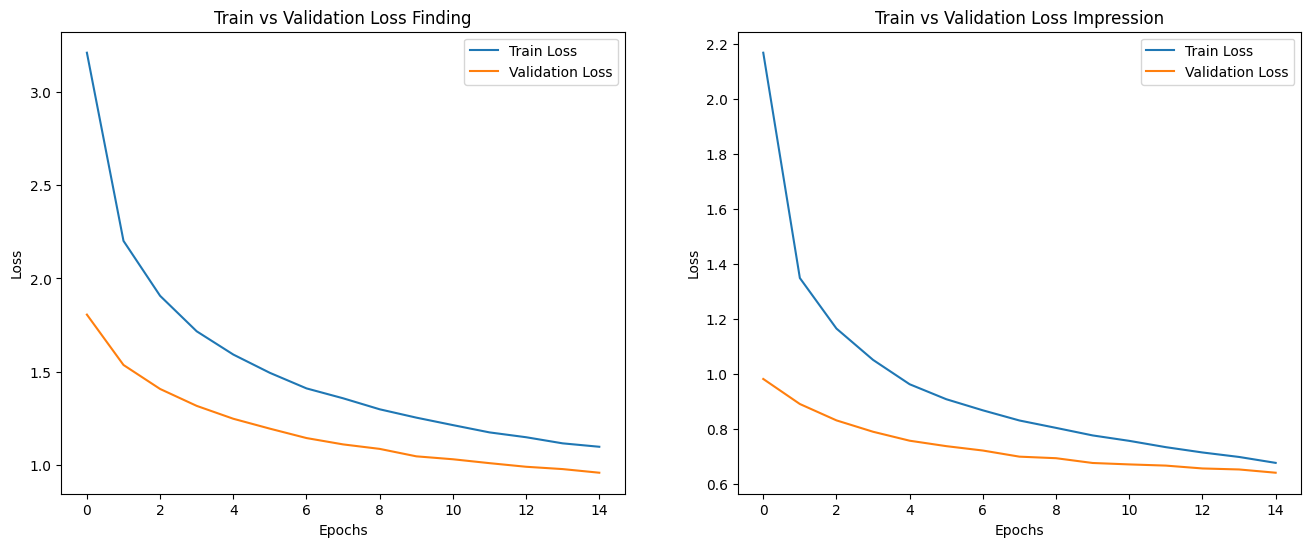

In [25]:
# Create a single figure with two subplots
plt.figure(figsize=(16, 6))

# Plot for Finding Losses
plt.subplot(1, 2, 1)
plt.plot(epoch_avg_train_loss_finding, label='Train Loss')
plt.plot(epoch_avg_val_loss_finding, label='Validation Loss')
plt.title('Train vs Validation Loss Finding')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.grid(False)

# Plot for Impression Losses
plt.subplot(1, 2, 2)
plt.plot(epoch_avg_train_loss_impression, label='Train Loss')
plt.plot(epoch_avg_val_loss_impression, label='Validation Loss')
plt.title('Train vs Validation Loss Impression')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.grid(False)

# Save the entire figure with both subplots
plt.savefig('train_val_loss_plots_combined.png', format='png', dpi=300)

# Show both plots
plt.show()

In [26]:
import os
import torch

# Define the save directory
save_directory = "./medical_report_model"
os.makedirs(save_directory, exist_ok=True)

# Save the model state dictionary
torch.save(model.state_dict(), os.path.join(save_directory, "medical_report_model.pth"))

# Save the tokenizer
tokenizer.save_pretrained(save_directory)

print(f"Model and tokenizer saved to {save_directory}")

Model and tokenizer saved to ./medical_report_model


# Save the model for later use

In [27]:
import os
import torch
from transformers import AutoTokenizer

# Path to the directory of the loaded dataset
saved_model_dir = "/kaggle/working/medical_report_model"

# Load the model
# tokenizer.add_tokens(["Findings:", "Impressions:"])
model = MedicalReportModel(tokenizer=tokenizer)  # Replace with your model class
# Add custom tokens (if needed)

#model.decoder.resize_token_embeddings(len(tokenizer))  
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.load_state_dict(torch.load(os.path.join(saved_model_dir, "medical_report_model.pth"), map_location=device))
model.to(device)

# Load the tokenizer
tokenizer = AutoTokenizer.from_pretrained(saved_model_dir)

print("Model and tokenizer loaded successfully!")

Some weights of GPT2LMHeadModel were not initialized from the model checkpoint at gpt2 and are newly initialized: ['h.0.crossattention.c_attn.bias', 'h.0.crossattention.c_attn.weight', 'h.0.crossattention.c_proj.bias', 'h.0.crossattention.c_proj.weight', 'h.0.crossattention.q_attn.bias', 'h.0.crossattention.q_attn.weight', 'h.0.ln_cross_attn.bias', 'h.0.ln_cross_attn.weight', 'h.1.crossattention.c_attn.bias', 'h.1.crossattention.c_attn.weight', 'h.1.crossattention.c_proj.bias', 'h.1.crossattention.c_proj.weight', 'h.1.crossattention.q_attn.bias', 'h.1.crossattention.q_attn.weight', 'h.1.ln_cross_attn.bias', 'h.1.ln_cross_attn.weight', 'h.10.crossattention.c_attn.bias', 'h.10.crossattention.c_attn.weight', 'h.10.crossattention.c_proj.bias', 'h.10.crossattention.c_proj.weight', 'h.10.crossattention.q_attn.bias', 'h.10.crossattention.q_attn.weight', 'h.10.ln_cross_attn.bias', 'h.10.ln_cross_attn.weight', 'h.11.crossattention.c_attn.bias', 'h.11.crossattention.c_attn.weight', 'h.11.crossat

Model and tokenizer loaded successfully!


In [28]:
!pip install rouge-score 

  Preparing metadata (setup.py) ... done
  Created wheel for rouge-score: filename=rouge_score-0.1.2-py3-none-any.whl size=24935 sha256=5971359bc20a73516528247a8b66999151dd753c8695f06e7402a5a2c5579a5e
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge-score


In [29]:
test_loader = DataLoader(test_ds, batch_size=8, collate_fn=batch_preprocessor)
test_loader = CustomDataLoader(test_loader)

26/26 ----- 100% batches loaded
Loaded 26 batches.


# Evaluate the model and Inference 
* BLEU 1, 2, 3, 4 and ROUGE-L are used for measuring the performance of our model

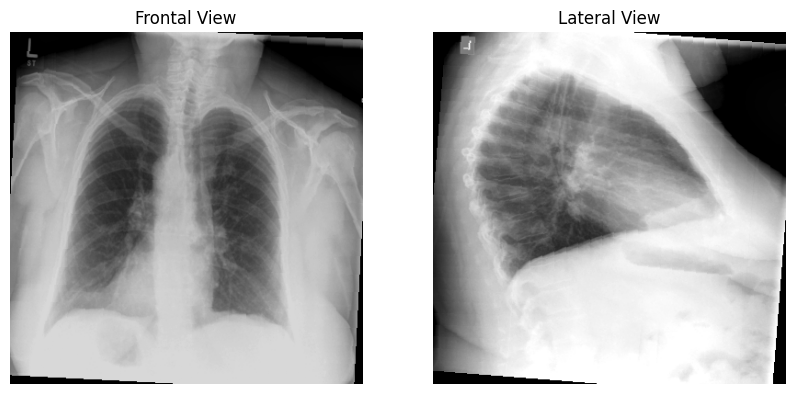

True Findings:
  Findings: the heart is normal in size. the mediastinum is stable. the lungs are clear.
Predicted Findings:
 ings: both lungs have in the interval. heart and mediastinum normal. degenerative changes of the thoracic spine.
--------------------------------------------------
True Impressions:
 Impressions: no acute disease.
Predicted Impressions:
 ressions: no acute disease.
--------------------------------------------------


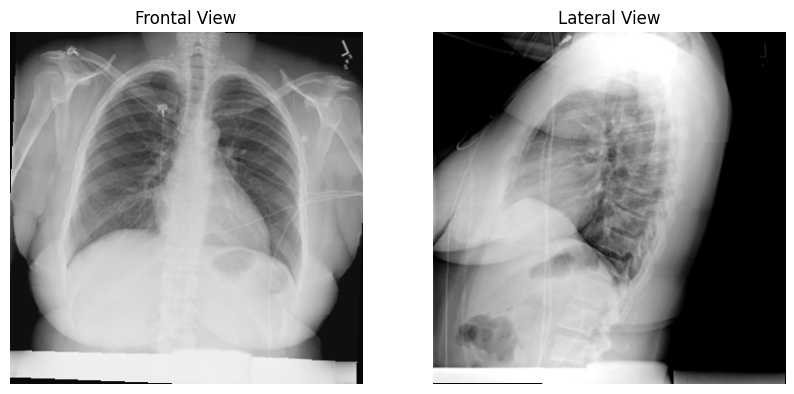

True Findings:
  Findings: the heart pulmonary and mediastinum are within normal limits. there is no pleural effusion or pneumothorax. there is no focal air space opacity to suggest a pneumonia. there minimal degenerative changes of the spine.
Predicted Findings:
 ressions: 1. no acute cardiopulmonary process. 2. stable pulmonary vascularity. 2. no pleural effusion.
--------------------------------------------------
True Impressions:
 Impressions: no acute cardiopulmonary disease.
Predicted Impressions:
 ressions: no acute cardiopulmonary abnormality. . 
--------------------------------------------------


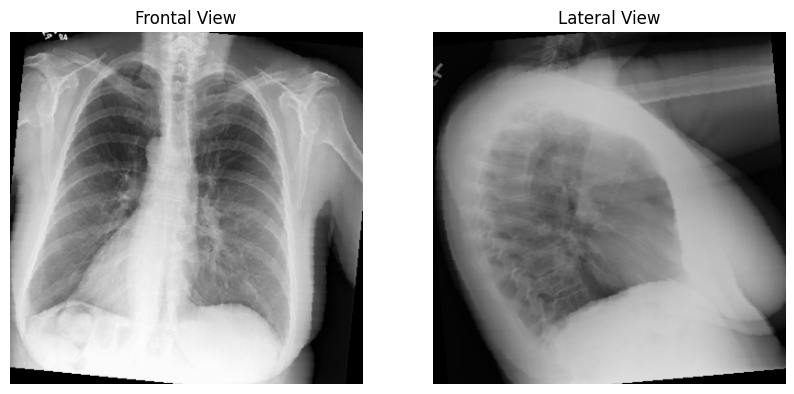

True Findings:
  Findings: the cardiac contours are normal. the lungs are clear. thoracic spondylosis.
Predicted Findings:
 ings: the cardiomediastinal silhouette is within normal limits. the pulmonary vasculature is unremarkable. there is no pneumothorax or pleural effusion. mild degenerative changes of the thoracic spine.
--------------------------------------------------
True Impressions:
 Impressions: no acute findings.
Predicted Impressions:
 ressions: 1. no acute cardiopulmonary disease.
--------------------------------------------------


Testing: 100%|██████████| 26/26 [00:29<00:00,  1.14s/it]


Test Results =:

BLEU Scores Findings:
BLEU-1 Score: 0.3749
BLEU-2 Score: 0.3131
BLEU-3 Score: 0.2745
BLEU-4 Score: 0.2435
ROUGE-L Score: 0.2265

BLEU Scores Impressions:
BLEU-1 Score: 0.4214
BLEU-2 Score: 0.3964
BLEU-3 Score: 0.3762
BLEU-4 Score: 0.3530
ROUGE-L Score: 0.2807


In [30]:
from rouge_score import rouge_scorer
import matplotlib.pyplot as plt
import warnings
import logging
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

import os

# Set the environment variable
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'

# Disable all warnings
warnings.filterwarnings('ignore')
# Ignore specific warnings from 'transformers'
warnings.filterwarnings("ignore", category=UserWarning, module="transformers")
# Set logging level to ERROR to ignore INFO and WARNING messages
logging.getLogger("transformers").setLevel(logging.ERROR)

def calculate_bleu(pred_ids, ref_ids, tokenizer):
    """
    Calculate BLEU-1, BLEU-2, BLEU-3, BLEU-4 scores.
    """
    pred_tokens = tokenizer.convert_ids_to_tokens(pred_ids)
    ref_tokens = tokenizer.convert_ids_to_tokens(ref_ids)

    # Avoid issues with empty sequences
    if not pred_tokens or not ref_tokens:
        return (0.0, 0.0, 0.0, 0.0)

    smoothing = SmoothingFunction().method1
    bleu1 = sentence_bleu([ref_tokens], pred_tokens, weights=(1, 0, 0, 0), smoothing_function=smoothing)
    bleu2 = sentence_bleu([ref_tokens], pred_tokens, weights=(0.5, 0.5, 0, 0), smoothing_function=smoothing)
    bleu3 = sentence_bleu([ref_tokens], pred_tokens, weights=(0.33, 0.33, 0.33, 0), smoothing_function=smoothing)
    bleu4 = sentence_bleu([ref_tokens], pred_tokens, weights=(0.25, 0.25, 0.25, 0.25), smoothing_function=smoothing)

    return bleu1, bleu2, bleu3, bleu4

def calculate_rouge_l(predicted_text, reference_text):
    scorer = rouge_scorer.RougeScorer(['rougeL'], use_stemmer=True)
    score = scorer.score(reference_text, predicted_text)
    return score['rougeL'].fmeasure
    
def test(model, test_loader, tokenizer):
    model.eval()
    total_finding_bleu1 = total_finding_bleu2 = total_finding_bleu3 = total_finding_bleu4 = 0
    total_finding_rouge_l = 0

    total_impression_bleu1 = total_impression_bleu2 = total_impression_bleu3 = total_impression_bleu4 = 0
    total_impression_rouge_l = 0

   
    with torch.no_grad():
        for batch in tqdm(test_loader, desc="Testing"):
            # Generate both reports
            findings_ids, impression_ids = model.generate_reports(
                frontal_image=batch['front_pixel_values'],
                lateral_image=batch['lateral_pixel_values'],
                # input_ids_finding = batch['input_ids_finding'],
                # input_ids_impression = batch['input_ids_impression'],
                device=device
            )

            # Calculate metrics separately
            # For findings
            # Calculate BLEU and ROUGE-L scores on generated finding texts
            
            for pred_finding_ids, ref_finding_ids in zip(findings_ids, batch['input_ids_finding']):
                # ... existing metric calculation code         
                bleu1, bleu2, bleu3, bleu4 = calculate_bleu(pred_finding_ids.tolist(), ref_finding_ids.tolist(), tokenizer)
                total_finding_bleu1 += bleu1
                total_finding_bleu2 += bleu2
                total_finding_bleu3 += bleu3
                total_finding_bleu4 += bleu4

                predicted_text = tokenizer.decode(pred_finding_ids.tolist(), skip_special_tokens=True)
                reference_text = tokenizer.decode(ref_finding_ids.tolist(), skip_special_tokens=True)
                rouge_l_score = calculate_rouge_l(predicted_text, reference_text)
                total_finding_rouge_l += rouge_l_score

             # Calculate BLEU and ROUGE-L scores on generated impression texts
              # For impressions
            for pred_ids, ref_ids in zip(impression_ids, batch['input_ids_impression']):
                bleu1, bleu2, bleu3, bleu4 = calculate_bleu(pred_ids.tolist(), ref_ids.tolist(), tokenizer)
                total_impression_bleu1 += bleu1
                total_impression_bleu2 += bleu2
                total_impression_bleu3 += bleu3
                total_impression_bleu4 += bleu4

                predicted_text = tokenizer.decode(pred_ids.tolist(), skip_special_tokens=True)
                reference_text = tokenizer.decode(ref_ids.tolist(), skip_special_tokens=True)
                rouge_l_score = calculate_rouge_l(predicted_text, reference_text)
                total_impression_rouge_l += rouge_l_score

    dataset_size = len(test_loader.dataset)
   
    finding_metrics = {
        'bleu1': total_finding_bleu1 / dataset_size,
        'bleu2': total_finding_bleu2 / dataset_size,
        'bleu3': total_finding_bleu3 / dataset_size,
        'bleu4': total_finding_bleu4 / dataset_size,
        'rouge_l': total_finding_rouge_l / dataset_size
    }

    print("\nTest Results =:")
    print("\nBLEU Scores Findings:")
    print(f"BLEU-1 Score: {finding_metrics['bleu1']:.4f}")
    print(f"BLEU-2 Score: {finding_metrics['bleu2']:.4f}")
    print(f"BLEU-3 Score: {finding_metrics['bleu3']:.4f}")
    print(f"BLEU-4 Score: {finding_metrics['bleu4']:.4f}")
    print(f"ROUGE-L Score: {finding_metrics['rouge_l']:.4f}")

    
    impression_metrics = {
        'bleu1': total_impression_bleu1 / dataset_size,
        'bleu2': total_impression_bleu2 / dataset_size,
        'bleu3': total_impression_bleu3 / dataset_size,
        'bleu4': total_impression_bleu4 / dataset_size,
        'rouge_l': total_impression_rouge_l / dataset_size
    }

    
    print("\nBLEU Scores Impressions:")
    print(f"BLEU-1 Score: {impression_metrics['bleu1']:.4f}")
    print(f"BLEU-2 Score: {impression_metrics['bleu2']:.4f}")
    print(f"BLEU-3 Score: {impression_metrics['bleu3']:.4f}")
    print(f"BLEU-4 Score: {impression_metrics['bleu4']:.4f}")
    print(f"ROUGE-L Score: {impression_metrics['rouge_l']:.4f}")

    return finding_metrics, impression_metrics

def visualize_predictions(model, test_loader, tokenizer, num_images=5):
    model.eval()
    visualizations_shown = 0

    with torch.no_grad():
        for batch in test_loader:
             findings_ids, impression_ids = model.generate_reports(
                    frontal_image=batch['front_pixel_values'],
                    lateral_image=batch['lateral_pixel_values'],
                    # input_ids_finding = batch['input_ids_finding'],
                    # input_ids_impression = batch['input_ids_impression'],
                    device=device
             )

             # print("Findinings Ids: ",findings_ids)
             # print("Impression Ids:", impression_ids)
    
             for i in range(len(findings_ids)):
                # pred_finding = tokenizer.decode(findings_ids[i], skip_special_tokens=True)
                # pred_impression = tokenizer.decode(impression_ids[i], skip_special_tokens=True)
                    if visualizations_shown >= num_images:
                            return

                    # Decode findings and impressions
                    pred_finding = tokenizer.decode(findings_ids[i].tolist(), skip_special_tokens=True)
                    true_finding = tokenizer.decode(batch['input_ids_finding'][i].tolist(), skip_special_tokens=True)
    
                    pred_impression = tokenizer.decode(impression_ids[i].tolist(), skip_special_tokens=True)
                    true_impression = tokenizer.decode(batch['input_ids_impression'][i].tolist(), skip_special_tokens=True)
                    
                    # Plot images
                    plt.figure(figsize=(10, 5))
    
                    # Plot frontal image
                    plt.subplot(1, 2, 1)
                    plt.imshow(batch['front_pixel_values'][i].cpu().permute(1, 2, 0))
                    plt.axis('off')
                    plt.title('Frontal View')
    
                    # Plot lateral image
                    plt.subplot(1, 2, 2)
                    plt.imshow(batch['lateral_pixel_values'][i].cpu().permute(1, 2, 0))
                    plt.axis('off')
                    plt.title('Lateral View')
    
                    plt.show()
    
                    # Print predictions and true values
                    print(f"True Findings:\n {true_finding}")
                    print(f"Predicted Findings:\n {pred_finding}")
                    print('-' * 50)
    
    
                    # Print predictions and true values
                    print(f"True Impressions:\n {true_impression}")
                    print(f"Predicted Impressions:\n {pred_impression}")
                    print('-' * 50)
    
                    visualizations_shown += 1

# Ensure the model is on the GPU before starting
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# inference_loaders =  list(test_loader)

# batch_inference = random.choice(inference_loaders)
# print(batch_inference)
# Run tests and visualize predictions
visualize_predictions(model, test_loader, tokenizer, num_images=3)

finding_metrics, impression_metrics = test(model, test_loader, tokenizer)